In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image


print(tf.__version__)

2.6.0


In [2]:

annotation_folder = './annotations/'
annotation_file = annotation_folder+'captions_train2014.json'
image_folder = '/train2014/'
PATH = os.path.abspath('.') + image_folder

with open(annotation_file, 'r') as f:
    annotations = json.load(f)
    
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [3]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
    
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [4]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A very clean and modern style  living room. <end>


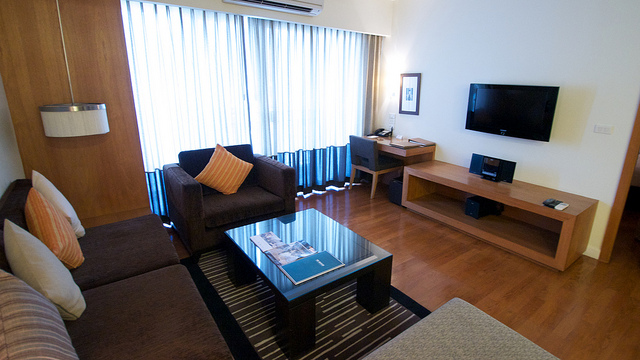

In [5]:
print(train_captions[0])
Image.open(img_name_vector[0])

In [6]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [7]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [8]:
from tqdm import tqdm

# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|████████████████████████████████████████████████████████████████████████████████| 375/375 [00:48<00:00,  7.77it/s]


In [8]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [9]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [10]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [11]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24011, 24011, 6007, 6007)

In [12]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [13]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [27]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [15]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [16]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [17]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [19]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [20]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [21]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [22]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [23]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [24]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [25]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    
    ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.1450
Epoch 1 Batch 100 Loss 1.1916
Epoch 1 Batch 200 Loss 1.0820
Epoch 1 Batch 300 Loss 0.9533
Epoch 1 Loss 1.111391
Time taken for 1 epoch 162.56 sec

Epoch 2 Batch 0 Loss 0.8992
Epoch 2 Batch 100 Loss 0.8772
Epoch 2 Batch 200 Loss 0.7953
Epoch 2 Batch 300 Loss 0.8589
Epoch 2 Loss 0.847718
Time taken for 1 epoch 74.24 sec

Epoch 3 Batch 0 Loss 0.8181
Epoch 3 Batch 100 Loss 0.7906
Epoch 3 Batch 200 Loss 0.7771
Epoch 3 Batch 300 Loss 0.7025
Epoch 3 Loss 0.763587
Time taken for 1 epoch 74.93 sec

Epoch 4 Batch 0 Loss 0.7984
Epoch 4 Batch 100 Loss 0.7070
Epoch 4 Batch 200 Loss 0.6977
Epoch 4 Batch 300 Loss 0.6413
Epoch 4 Loss 0.706947
Time taken for 1 epoch 75.51 sec

Epoch 5 Batch 0 Loss 0.6928
Epoch 5 Batch 100 Loss 0.7198
Epoch 5 Batch 200 Loss 0.6316
Epoch 5 Batch 300 Loss 0.6995
Epoch 5 Loss 0.663474
Time taken for 1 epoch 75.50 sec

Epoch 6 Batch 0 Loss 0.6396
Epoch 6 Batch 100 Loss 0.6404
Epoch 6 Batch 200 Loss 0.6272
Epoch 6 Batch 300 Loss 0.6424
Epoch 6 Los

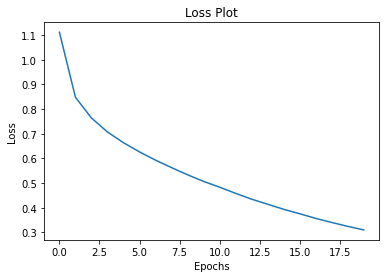

In [26]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [27]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [28]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

C:\Users\multicampus\Desktop\th\mscoco/train2014/COCO_train2014_000000401218.jpg

Real Caption: <start> a shaggy dog laying behind a square cake <end>
Prediction Caption: a large brown and <unk> the small container next to it <end>


<ipython-input-28-81c52a4eee3c>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(grid_size, grid_size, i+1)


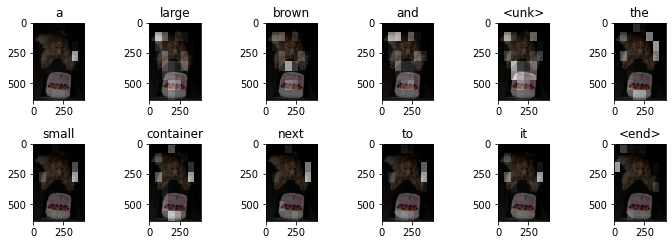

In [44]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

print(img_name_val[rid])
print()

real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Prediction Caption: a man that is riding the wave <end>


<ipython-input-28-81c52a4eee3c>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(grid_size, grid_size, i+1)


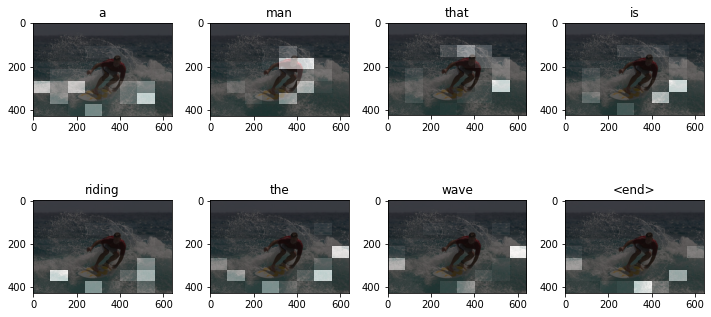

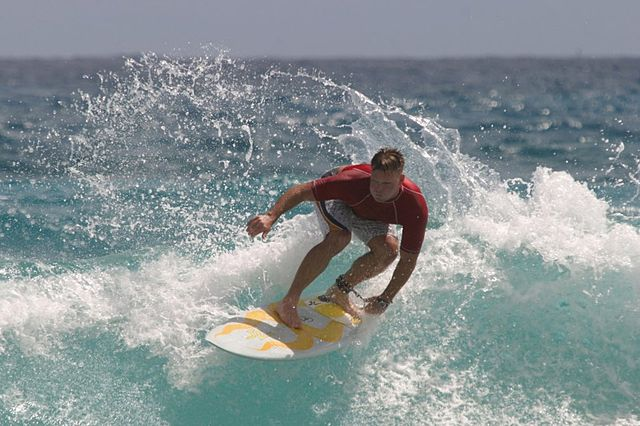

In [30]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [33]:
encoder.save_weights('encoder_weights.hdf5')

In [34]:
decoder.save_weights('decoder_weights.hdf5')

In [19]:
import pickle

len(train_captions)
with open('train_captions.pkl', 'wb') as f:
    pickle.dump(train_captions, f)

In [35]:
# import tensorflow as tf
# import numpy as np


top_k = 5000

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

with open('train_captions.pkl', 'rb') as f:
    train_captions = pickle.load(f)

train_seqs = tokenizer.texts_to_sequences(train_captions)

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

def calc_max_length(tensor):
    return max(len(t) for t in tensor)

max_length = calc_max_length(train_seqs)



new_encoder = CNN_Encoder(embedding_dim)
new_decoder = RNN_Decoder(embedding_dim, units, vocab_size)

new_encoder.load_weights('encoder_weights.hdf5')
new_decoder.load_weights('decoder_weights.hdf5')


def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path


def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    
    features = encoder(img_tensor_val)
    

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


my_img_path = 'img.jpg'
result, attention_plot = evaluate(my_img_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(my_img_path, result, attention_plot)

Image.open(image_path)

tf.Tensor(
[[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.57550251e-01 0.00000000e+00]
   [0.00000000e+00 1.38390821e-03 0.00000000e+00 ... 0.00000000e+00
    1.27917373e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.12235510e-01
    2.57416892e+00 1.49165794e-01]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.30369464e-02
    1.83283627e+00 6.68365955e-01]
   [0.00000000e+00 0.00000000e+00 4.82802153e-01 ... 0.00000000e+00
    5.50785661e-01 3.05431932e-01]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    2.87464142e-01 1.15734331e-01]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    8.99752438e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.70323968e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.04647893e-01
    3.13179064e+00 7.09873661e-02]
   ...
   [6.77325428e-01 0.00000000e+00 0.00000000e+

NameError: name 'target' is not defined